# Analyse Tortenguss

First you can find the imports and the picture paths. Currently absolute paths are used, so you **need to adjust this path** in order to get the code running. Furthermore picture specific properties such as the raw pattern are defined. They were read out manually. The showArray function can be used for debugging purposes.

In [7]:
import numpy as np
import rawpy
import matplotlib.pyplot as plt
import csv
import datetime
import os
from matplotlib import pyplot as plt
from scipy.stats import linregress
import timeit

cwd = os.getcwd()
images = os.path.dirname(cwd) + "/experiments/tortenguss-diffusion/pictures/"
areas = images + "areas.csv"
color_desc = {0: "R", 1: "G", 2: "B", 3: "G"}
raw_pattern = [[1,0], [2,3]]
col_raw_pattern = [["G","R"], ["B","G"]]

def showArray(arr):
    plt.imshow(arr, interpolation='nearest')
    plt.show()

def getAllPaths():
    return [os.path.join(images, f) for f in os.listdir(images) if (os.path.isfile(os.path.join(images, f))==True)&(str(f) != '.DS_Store')&(str(f) != 'areas.csv')]

Now we define a function, that gives us the boundaries for a certain image, as defined in the areas.csv file.

In [4]:
def boundaries(key):
    csv_path = images + "areas.csv"
    with open(csv_path) as csvfile:
        csvreader = csv.reader(csvfile, delimiter = ";")
        for row in csvreader:
            if row[1] == "NA":
                raise RuntimeError("Areas not defined.")
            if row[0] == key:
                return (int(row[1]), int(row[2]), int(row[3]), int(row[4]))

The read function reads in an image and returns the black value and an array containing the pixel values of the image.

In [5]:
def read(key, path=images+"181015.dng"):
    x, y, xlen, ylen = boundaries(key)
    y = y + y%2
    x = x + x%2
    xlen = xlen + xlen%2
    ylen = ylen + ylen%2
    img_data = None
    with rawpy.imread(path) as raw: # if you want to run non object version, replace 1.dng by {timestamp}.dng
        img_data = raw.raw_image.copy()
        black = np.array(raw.black_level_per_channel).mean()
    ret = img_data[y:y+ylen,x:x+xlen]
    return (ret, black)

The intensity function gives us the intensity depending on two arrays and their black values, as well as a colour value. The intensities function, does this but accepts instead of arrays and black values, keys, as found in areas.csv and a reader function. This argument can be used for rasterization, as explained below.

In [14]:
def intensities(key, ctrl_key, col=None, reader_func=read):
    ret, black = reader_func(key)
    retctrl, blackctrl = read(ctrl_key)
    x, y, xlen, ylen = boundaries(key)
    if ret.shape  == (ylen, xlen):
        return intensity(ret, retctrl, black, blackctrl, col)
    else:
        return [intensity(arr, retctrl, black, blackctrl, col) for arr in ret]

def intensity(arr, arr_ctrl, black, black_ctrl, col):
    #showArray(arr)
    #showArray(arr_ctrl)
    val = (singleColorArray(col, arr).mean()-black)
    c_val = (singleColorArray(col, arr_ctrl).mean()-black_ctrl)
    return np.log10(c_val/val)

The single color array function, returns from a given array only those pixels, that are of the provided color. They are put into a single list.

In [5]:
def old_singleColorArray(target_color, arr):
    if target_color == None:
        return arr
    new_arr = []
    for index_r, row in enumerate(arr):
        for index_c, col in enumerate(row):
            r_ind = index_r
            c_ind = index_c
            color = None 
            if r_ind % 2 == 0:
                if c_ind % 2 == 0:
                    color = 1
                else:
                    color = 0
            else:
                if c_ind % 2 == 0:
                    color = 2
                else:
                    color = 3
            if color_desc[color] == target_color:
                new_arr.append(col)
            else:
                pass
    return np.array(new_arr)

def singleColorArray(target_color, arr):
    if target_color == None:
        return arr
    new_arr = []
    for index_r, row in enumerate(arr):
        if target_color not in col_raw_pattern[index_r%2]:
            continue
        else:
            local_col_raw_pattern = col_raw_pattern[index_r%2]
            if local_col_raw_pattern[row[0]%2] == target_color:
                first = True
            else:
                first = False
            for index_c, col in enumerate(row):
                if first:
                    new_arr.append(col)
                first = not first
    return np.array(new_arr) 

The rasterization functions raster an image into rows of a certain height, they then return an array containing subarrays of the original array, but with the provided height. The defined convenience function make the usage with the intensities function easier and allow for easy plotting.

In [11]:
def rasterizeImage(key, row_height=None, x_coords=False):
    rows = []
    arr, black = read(key)
    x, y, xlen, ylen = boundaries(key)
    if row_height == None:
        row_height = ylen
    ylen = ylen - ylen%row_height #this guarantees, that also the last row has row_height
    row_no = int(ylen/row_height)
    if x_coords:
        return [n for n in range(row_no)][:]
    rows = [arr[n*row_height:(n+1)*row_height] for n in range(row_no)]
    return (np.array(rows), black)

def rasterizeImageWrapperGenerator(row_height=None):
    def _rasterize(_key):
        return rasterizeImage(_key, row_height=row_height)
    return _rasterize

def rasterXCoords(key, row_height=None):
    return rasterizeImage(key, row_height=row_height, x_coords=True)

raster = rasterizeImageWrapperGenerator #definition for ease of use

And now we analyze the data.

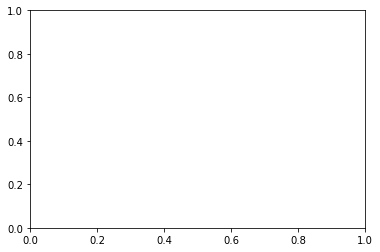

In [32]:
def plotFor(key, all=False, ax=plt.subplot(111)):
    ax.plot(rasterXCoords("{}".format(key), 2),intensities("{}".format(key), "{}-ctrl".format(key), reader_func=raster(2)), color="k")
    if all:
        ax.plot(rasterXCoords("{}".format(key), 2),intensities("{}".format(key), "{}-ctrl".format(key), col="B", reader_func=raster(2)), color="b")
        ax.plot(rasterXCoords("{}".format(key), 2),intensities("{}".format(key), "{}-ctrl".format(key), col="R", reader_func=raster(2)), color="r")
        ax.plot(rasterXCoords("{}".format(key), 2),intensities("{}".format(key), "{}-ctrl".format(key), col="G", reader_func=raster(2)), color="g")

def plotKeys(keys):
    fig, axs = plt.subplots(len(keys),1)
    for pos, key in enumerate(keys):
        plotFor(key, ax=axs[pos], all=True)

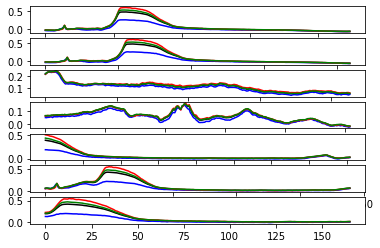

In [33]:
plotKeys(["181015","181600", "184358", "184438", "184734", "192135", "194705"])

Nun die objektorientierte Version.

In [2]:
class Camera:
    
    def __init__(self, raw_pattern, color_desc):
        self.pattern = raw_pattern
        self.colors = color_desc

ios = Camera([[0,1], [3,2]], {0: "R", 1: "G", 2: "B", 3: "G"})
android = Camera([[1,0], [2,3]] ,{0: "R", 1: "G", 2: "B", 3: "G"})        

class Boundary:
    
    def __init__(self, x, y, xlen, ylen):
        self.x = x - x%2
        self.y = y - y%2
        self.xlen = xlen - xlen%2
        self.ylen = ylen - ylen%2
        
class Frame(Boundary):
    
    def __init__(self, x, y, xlen, ylen, valid_pixels):
        super.init(x, y, xlen, ylen)
        self.valid_pixels = valid_pixels
        
    def is_pixel_valid(self, x, y):
        if (x>=self.x) and (x<=(self.x + self.xlen)) and (y>=self.y) and (y<=(self.y + self.ylen)):
            transformed_x = self.x - x
            transformed_y = self.y - y
            if transformed_x >= 0 and transformed_y >= 0 and self.valid_pixels[transformed_y, transformed_x]:
                return True
        return False
        
        
class XBoundary(Boundary):
    
    def __init__(self, x):
        self.x = x

class DiffusionTimeSeries:
    
    @staticmethod
    def timeDiff(time1, time2):
        return (time1-time2).absolute_seconds()
    
    def __init__(self, starting_point):
        self.starting_time = datetime.datetime.strptime(starting_point, "%H%M%S")
        self.measurements = []
        self.raster_max_y = None
        self.times = []
        
    def add_measurement(self, measurement):
        self.measurements.append(measurement)
        
    def rasterize_all_measurements(self, row_height):
        _ = [n.rasterize(row_height) for n in measurements]

    def get_max_y_raster(self):
        raster_coords = [max(n.rasterized_x_coords) for n in measurements]
        self.raster_max_y = min(raster_coords)
        
    def intensities(self, position):
        intensities = []
        for measurement in measurements:
            prevxcoord = -1
            for pos, xcoord in enumerate(measurement.rasterized_x_coords):
                if position>=prevxcoord and position<xcoord:
                    intensities.append(DiffusionMeasurement.intensity(measurement.rasterized_main[pos], measurement.black))
                    break
                prevxcoord = xcoord
        return intensities

    def update_times(self):
        self.times = []
        for measurement in self.measurements:
            self.times.append(DiffusionTimeSeries.timeDiff(measurement.time ,self.starting_time))

class ExperimentManager:
    
    @staticmethod
    def getMeasurementObjects(camera=android, complete_main_boundaries_used=True, path=images):
        files = []
        measurements = []
        for file in os.listdir(path):
            if file.endswith(".dng"):
                files.append(file)
        files.sort()
        for file in files:
                keys = ["{}-ctrl".format(file.split(".")[0]),"{}".format(file.split(".")[0]) ]
                measurements.append(DiffusionMeasurement(file, keys[0], path+"areas.csv", camera, keys[1], complete_main_boundaries_used))
        return measurements
    
    
    @staticmethod
    def getTimeSeries(starting_point, row_height, camera=android, complete_main_boundaries_used=True, path=images):
        measurements = ExperimentManager.getMeasurementObjects(camera, complete_main_boundaries_used, path)
        time_series = DiffusionTimeSeries(starting_point)
        for measurement in measurements:
            time_series.add_measurement(measurement)
        time_series.rasterize_all_measurements(row_height)
        time_series.get_max_y_raster()
        time_series.update_times()
        return time_series
    
    
class DiffusionMeasurement:
    
    @staticmethod
    def intensity(pixels, constant_offset):
        return pixels.mean() - constant_offset
    
    @staticmethod
    def absorbance(val, ctrl):
        np.log10(ctrl/val)
    
    @staticmethod
    def single_color_intensity(pixels, constant_offset, colour_key, camera):
        single_colour_array = DiffusionMeasurement.colour_filtered_array(pixels, colour_key, camera)
        return DiffusionMeasurement.intensity(single_colour_array, constant_offset)
    
    @staticmethod
    def colour_filtered_array(array, colour, camera):
        new_list = []    
        for r_ind, row in enumerate(array):
            for c_ind, col in enumerate(row):
                if r_ind % 2 == 0:
                    if c_ind % 2 == camera.pattern[0][0]:
                        local_colour = camera.pattern[0][0]
                    else:
                        local_colour = camera.pattern[0][1]
                else:
                    if c_ind % 2 == camera.pattern[1][0]:
                        local_colour = camera.pattern[1][0]
                    else:
                        local_colour = camera.pattern[1][1]
                if camera.colors[local_colour] == colour:
                    new_list.append(col)
        return np.array(new_list)
    
    def __init__(self, path, control_key, boundaries_file, camera, main_key, complete_main_boundaries_used = False):
        self.camera = camera
        self.rasterized_main = None
        self.rasterized_x_coords = None
        
        with rawpy.imread(path) as raw_file:
            self.pixels = raw_file.raw_image.copy()
            self.black = np.array(raw_file.black_level_per_channel.mean).mean()
            
        with open(boundaries_file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter = ";")
            for row in csv_reader:
                if row[0] == control_key:
                    self.control_boundaries = Boundary(int(row[1]), int(row[2]), int(row[3]), int(row[4]))
                if row[0] == main_key:
                    if complete_main_boundaries_used:
                        self.main_boundaries = Boundary(int(row[1]), int(row[2]), int(row[3]), int(row[4]))
                        self.frame = Frame(int(row[1]), int(row[2]), int(row[3]), int(row[4]), np.ones((int(row[4]), int(row[3]))))
                    else:
                        self.main_boundaries = XBoundary(int(row[1]))
        
        if (complete_main_boundaries_used) == False:
            pass
        # initialize boundaries without main
            
        prelim_raw = self.pixels[self.frame.y:self.frame.ylen][self.frame.x:self.frame.xlen]
        for r_ind, row in enumerate(prelim_raw):
            for c_ind, col in enumerate(row):
                if (self.frame.is_pixel_valid(c_ind, r_ind)) == False:
                    prelim_raw[r_ind, c_ind] = np.nan
        self.main_pixels = prelim_raw
        self.ctrl_intensity = DiffusionMeasurement.intensity(self.pixels[self.control_boundaries.y:self.control_boundaries.ylen][self.control_boundaries.x:self.control_boundaries.xlen], self.black)
        self.time = datetime.datetime.strptime(path.split(".")[0],"%H%M%S")
        
    def rasterize(self, row_height):
        rows = []
        rasterizable_height = self.frame.ylen - self.frame.ylen%row_height
        row_no = int(rasterizable_height/row_height)
        self.rasterized_x_coords = [n*row_height for n in enumerate(row_no)]
        rows = [self.main_pixels[n*row_height:(n+1)*row_height] for n in range(row_no)]
        self.rasterized_main = np.array(rows)
        assert len(self.rasterized_x_coords) == len(list(self.rasterized_main))        
            
            
            



In [51]:
def checkPerformanceSingleColorArray(keys):
    for key in keys:
        with rawpy.imread(images + key + ".dng") as raw:
            arr = raw.raw_image.copy()
        
checkPerformanceSingleColorArray(["181015"])

Working for key 181015
old: 5.599, new: 28.8, diff: -23.201
False
